# Exercise 1: Variational autoencoders
Exercise by [Jes Frellsen](https://frellsen.org) (Technical University of Denmark), June 2024 (version 1.0).

In this programming exercise, you will work with variational autoencoders (VAEs). We consider a binarised version of the MNIST dataset, where pixels with values over $0.5$ are set to $1$ and pixels with values less than $0.5$ are set to $0$.

The provided code is a modular and simple implementation of a VAE with
* a Gaussian prior, $p(\mathbf{z})$,
* a product of Bernoulli likelihood, $p(\mathbf{x}|\mathbf{z})$,
* a fully connected encoder and decoder network.

The implementation makes use of [`torch.distributions`](https://pytorch.org/docs/stable/distributions.html) for the various distributions, which substantially simplifies the code.

The code is followed by three exercises you have to solve.

This implementation in the notebook takes inspiration from:
* https://github.com/jmtomczak/intro_dgm/blob/main/vaes/vae_example.ipynb
* https://github.com/kampta/pytorch-distributions/blob/master/gaussian_vae.py



## Implementing the VAE
**VAE implementation:** Below we provide a complete implementation of the VAE.

In [1]:
import torch
import torch.nn as nn
import torch.distributions as td

class GaussianPrior(nn.Module):
    def __init__(self, M):
        """
        Define a Gaussian prior distribution with zero mean and unit variance.

                Parameters:
        M: [int] 
           Dimension of the latent space.
        """
        super(GaussianPrior, self).__init__()
        self.M = M
        self.mean = nn.Parameter(torch.zeros(self.M), requires_grad=False)
        self.std = nn.Parameter(torch.ones(self.M), requires_grad=False)

    def forward(self):
        """
        Return the prior distribution.

        Returns:
        prior: [torch.distributions.Distribution]
        """
        return td.Independent(td.Normal(loc=self.mean, scale=self.std), 1)


class GaussianEncoder(nn.Module):
    def __init__(self, encoder_net):
        """
        Define a Gaussian encoder distribution based on a given encoder network.

        Parameters:
        encoder_net: [torch.nn.Module]             
           The encoder network that takes as a tensor of dim `(batch_size,
           feature_dim1, feature_dim2)` and output a tensor of dimension
           `(batch_size, 2M)`, where M is the dimension of the latent space.
        """
        super(GaussianEncoder, self).__init__()
        self.encoder_net = encoder_net

    def forward(self, x):
        """
        Given a batch of data, return a Gaussian distribution over the latent space.

        Parameters:
        x: [torch.Tensor] 
           A tensor of dimension `(batch_size, feature_dim1, feature_dim2)`
        """
        mean, std = torch.chunk(self.encoder_net(x), 2, dim=-1)
        return td.Independent(td.Normal(loc=mean, scale=torch.exp(std)), 1)


class BernoulliDecoder(nn.Module):
    def __init__(self, decoder_net):
        """
        Define a Bernoulli decoder distribution based on a given decoder network.

        Parameters: 
        encoder_net: [torch.nn.Module]             
           The decoder network that takes as a tensor of dim `(batch_size, M) as
           input, where M is the dimension of the latent space, and outputs a
           tensor of dimension (batch_size, feature_dim1, feature_dim2).
        """
        super(BernoulliDecoder, self).__init__()
        self.decoder_net = decoder_net

    def forward(self, z):
        """
        Given a batch of latent variables, return a Bernoulli distribution over the data space.

        Parameters:
        z: [torch.Tensor] 
           A tensor of dimension `(batch_size, M)`, where M is the dimension of the latent space.
        """
        logits = self.decoder_net(z)
        return td.Independent(td.Bernoulli(logits=logits), 2)


class VAE(nn.Module):
    """
    Define a Variational Autoencoder (VAE) model.
    """
    def __init__(self, prior, decoder, encoder):
        """
        Parameters:
        prior: [torch.nn.Module] 
           The prior distribution over the latent space.
        decoder: [torch.nn.Module]
              The decoder distribution over the data space.
        encoder: [torch.nn.Module]
                The encoder distribution over the latent space.
        """
            
        super(VAE, self).__init__()
        self.prior = prior
        self.decoder = decoder
        self.encoder = encoder

    def elbo(self, x):
        """
        Compute the ELBO for the given batch of data.

        Parameters:
        x: [torch.Tensor] 
           A tensor of dimension `(batch_size, feature_dim1, feature_dim2, ...)`
           n_samples: [int]
           Number of samples to use for the Monte Carlo estimate of the ELBO.
        """
        q = self.encoder(x)
        z = q.rsample()
        # print shapes
        # print("shapes: ", self.decoder(z).log_prob(x).shape, td.kl_divergence(q, self.prior()).shape)
        # print("shapes inner: ", self.decoder(z).log_prob(x)[0].shape, td.kl_divergence(q, self.prior())[0].shape)
        elbo = torch.mean(self.decoder(z).log_prob(x) - td.kl_divergence(q, self.prior()), dim=0)
        return elbo

    def sample(self, n_samples=1):
        """
        Sample from the model.
        
        Parameters:
        n_samples: [int]
           Number of samples to generate.
        """
        z = self.prior().sample(torch.Size([n_samples]))
        return self.decoder(z).sample()
    
    def forward(self, x):
        """
        Compute the negative ELBO for the given batch of data.

        Parameters:
        x: [torch.Tensor] 
           A tensor of dimension `(batch_size, feature_dim1, feature_dim2)`
        """
        return -self.elbo(x)

**Training loop**: We have also implemented a generic training loop for learning the VAE model.

In [2]:
from tqdm.notebook import tqdm

def train(model, optimizer, data_loader, epochs, device):
    """
    Train a Flow model.

    Parameters:
    model: [Flow]
       The model to train.
    optimizer: [torch.optim.Optimizer]
         The optimizer to use for training.
    data_loader: [torch.utils.data.DataLoader]
            The data loader to use for training.
    epochs: [int]
        Number of epochs to train for.
    device: [torch.device]
        The device to use for training.
    """
    model.train()

    total_steps = len(data_loader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    for epoch in range(epochs):
        data_iter = iter(data_loader)
        for x in data_iter:
            if isinstance(x, (list, tuple)):
                x = x[0]
            x = x.to(device)
            optimizer.zero_grad()
            loss = model(x)
            loss.backward()
            optimizer.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}")
            progress_bar.update()

**Training data**: Next, we load MNIST as binarized at `thresshold` and create data loaders for training and test.

In [3]:
from torchvision import datasets, transforms

batch_size = 32
thresshold = 0.5
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: (thresshold < x).float().squeeze())])

mnist_train_loader = torch.utils.data.DataLoader(datasets.MNIST('data/', train=True, download=True, transform=transform), batch_size=batch_size, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(datasets.MNIST('data/', train=False, download=True, transform=transform), batch_size=batch_size, shuffle=True)

**Initialize the model and run the training loop**: Finally we initialize the model using a simple fully connected encoder and decoder networks and run the training loop. The networks are very simple to keep training time low.

In [4]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define prior distribution with dimension M
M = 2
prior = GaussianPrior(M)

# Define encoder and decoder networks
encoder_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, M*2),
)

decoder_net = nn.Sequential(
    nn.Linear(M, 128),
    nn.ReLU(),
    nn.Linear(128, 784),
    nn.Unflatten(-1, (28, 28))
)

# Define VAE model
decoder = BernoulliDecoder(decoder_net)
encoder = GaussianEncoder(encoder_net)
model = VAE(prior, decoder, encoder).to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters())

# Train model
epochs = 10
train(model, optimizer, mnist_train_loader, epochs, device)

Training:   0%|          | 0/18750 [00:00<?, ?it/s]

**Sampling**: The following code samples from a trained model and plots the samples

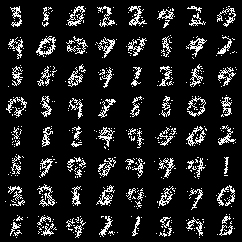

In [5]:
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
from IPython.display import display

model.eval()
with torch.no_grad():
    samples = (model.sample(64)).cpu()

image_pil = to_pil_image(make_grid(samples.view(-1, 1, 28, 28)))
display(image_pil)

## Exercises

### Exercise 1.1

In this first exercise, you should just inspect the VAE code above and answer the following questions:
* How is the reparametrisation trick handled in the code?
* Consider the implementation of the ELBO. What is the dimension of `self.decoder(z).log_prob(x)` and of `td.kl_divergence(q, self.prior.distribuion)`?
* The implementation of the prior, encoder and decoder classes all make use of `td.Independent`. What does this do?
* What is the purpose using the function `torch.chunk` in `GaussianEncoder.forward`?

**Answers:**


* How is the reparametrisation trick handled in the code?
    
    The reparametrisation trick is handled in the code by using the rsample() method of the distribution object. This method returns a sample from the distribution that is differentiable with respect to the parameters of the distribution. This allows us to compute the gradient of the ELBO with respect to the parameters of the encoder network, which can then be used to update the parameters of the network using gradient descent.


* Consider the implementation of the ELBO. What is the dimension of `self.decoder(z).log_prob(x)` and of `td.kl_divergence(q, self.prior.distribuion)`?

    The dimension of `self.decoder(z).log_prob(x)` is `(batch_size))`. The dimension of `td.kl_divergence(q, self.prior.distribution)` is `(batch_size,)`.

* The implementation of the prior, encoder and decoder classes all make use of `td.Independent`. What does this do?

    The `td.Independent` class is used to create a distribution that is a product of independent distributions.

* What is the purpose using the function `torch.chunk` in `GaussianEncoder.forward`?

    The `torch.chunk` function is used to split the output of the encoder network into two parts; the mean and the standard deviation of the Gaussian distribution over the latent space.

### Exercise 1.2

Add the following functionally to the implementation of the VAE with Bernoulli output distributions:
* Evaluate the ELBO on the binarised MNIST test set.
* Plot samples from the approximate posterior and colour them by their correct class label for each datapoint in the test set (i.e., samples from the aggregate posterior) for a two-dimensional latent space, i.e., $M=2$.
* *Optional:* The decoder and encoder networks above are very simple. Try to make the model more expressive by making the networks wider/deeper and increase the dimension of the latent space. Plot the aggregate posterior for $M>2$ by doing PCA and project the sample onto the first two principal components (e.g., using scikit-learn).


train elbo: -4.791568216451009
test elbo: -4.838970393371582


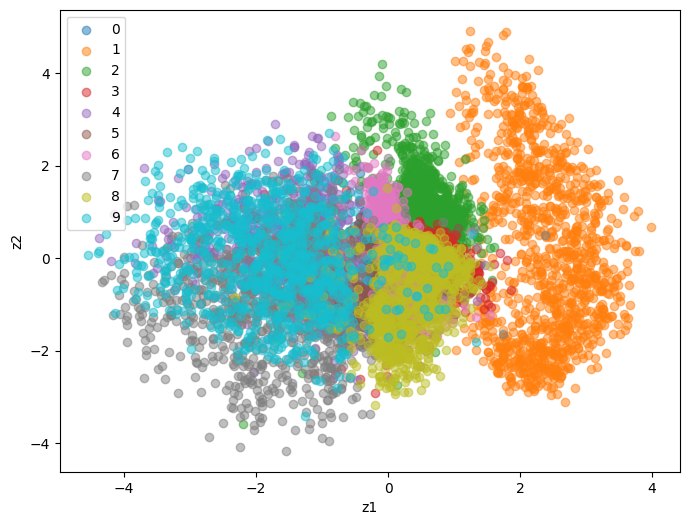

In [9]:
import matplotlib.pyplot as plt

# Exercise 1.2
# Add the following functionally to the implementation of the VAE with Bernoulli output distributions:

# Evaluate the ELBO on the binarised MNIST test set.
def evaluate_elbo(model, data_loader, device):
    """
    Evaluate the ELBO on the given dataset.

    Parameters:
    model: [Flow]
       The model to evaluate.
    data_loader: [torch.utils.data.DataLoader]
            The data loader to use for evaluation.
    device: [torch.device]
        The device to use for evaluation.
    """
    # Set model to evaluation mode
    model.eval()
    
    # Initialize ELBO
    elbo = 0
    
    # Loop through data loader
    for x in data_loader:
        # Move data to device
        x = x[0].to(device)
        # Compute ELBO
        elbo += torch.sum(model.elbo(x)).item()
        
    # Return average ELBO
    return elbo / len(data_loader.dataset)

train_elbo = evaluate_elbo(model, mnist_train_loader, device)
test_elbo = evaluate_elbo(model, mnist_test_loader, device)
print(f"train elbo: {train_elbo}")
print(f"test elbo: {test_elbo}")


# Plot samples from the approximate posterior and colour them by their correct class label for each datapoint in the test set (i.e., samples from the aggregate posterior) for a two-dimensional latent space, i.e., $M=2$.
def plot_aggregate_posterior(model, data_loader, device):
    """
    Plot samples from the aggregate posterior.

    Parameters:
    model: [Flow]
       The model to use for sampling.
    data_loader: [torch.utils.data.DataLoader]
            The data loader to use for evaluation.
    device: [torch.device]
        The device to use for evaluation.
    """
    # Set model to evaluation mode
    model.eval()
    
    # Initialize variables
    zs = []
    labels = []
    
    # Loop through data loader
    for x, y in data_loader:
        # Move data to device
        x = x.to(device)
        # Compute posterior
        q = model.encoder(x)
        # Sample from posterior
        z = q.sample()
        # Append to list
        zs.append(z)
        labels.append(y)
        
    # Concatenate tensors
    zs = torch.cat(zs)
    labels = torch.cat(labels)
    
    # Plot samples
    plt.figure(figsize=(8, 6))
    for i in range(10):
        plt.scatter(zs[labels == i, 0], zs[labels == i, 1], label=str(i), alpha=0.5)
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.legend()
    plt.show()

plot_aggregate_posterior(model, mnist_test_loader, device)

# *Optional:* The decoder and encoder networks above are very simple. Try to make the model more expressive by making the networks wider/deeper and increase the dimension of the latent space. Plot the aggregate posterior for $M>2$ by doing PCA and project the sample onto the first two principal components (e.g., using scikit-learn).

### Exercise 1.3

Extend the VAE with Bernoulli output distributions to use a mixture of Gaussian prior (MoG). We recommend using the [`MixtureSameFamily`](https://pytorch.org/docs/stable/distributions.html#mixturesamefamily) class from [`torch.distributions`](https://pytorch.org/docs/stable/distributions.html), but you are also welcome to implement it from scratch. For your implementation of the VAE with the MoG prior:
* Evaluate the test set ELBO. Do you see better performance?
* Plot the samples from the approximate posterior. How does it differ from the model with the Gaussian prior? Do you see better clustering?

**Remark**: You will need to change the implementation of the ELBO.